In [50]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import matplotlib.pyplot as plt
from re import split
from dask_jobqueue import SLURMCluster
from matplotlib.colors import LinearSegmentedColormap
from dask.distributed import Client, progress
from IPython.display import Image
  

import warnings

warnings.filterwarnings('ignore')

In [7]:
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_proj = get_pars_from_ini(file_name='loc.ini')[location]['path_proj']
path_data = get_pars_from_ini(file_name='loc.ini')[location]['path_data']

In [47]:
def get_eventst(ds, time_lenght=30, time_break=30, tot_counts=10):
    """
    param ds: Xarray dataset with count bin (cnt_bin) matrix
    param time_lenght: Minimum duration of the event
    param time_break: Maximum duration of a time break between events
    param tot_counts: Minimum total number of particles within the count bin spectra
    """
    ev = ds.cnt_bin.sum('diameter').where(ds.cnt_bin.sum('diameter') > tot_counts)
    ev = ev[ev.notnull()]
    a = ev.time.diff('time').to_dataframe('date') 
    sec = pd.Timedelta('30S') 
    breaks = a >= sec
    groups = breaks.cumsum()
    start = [i[1].index.min() for i in groups.groupby('date') if i[1].shape[0] > time_lenght]
    end = [i[1].index.max() for i in groups.groupby('date') if i[1].shape[0] > time_lenght]
    return start, end

def add_colorbar_outside(im, ax, label):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.01
    eps = 0.06 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax, label=label)
    
    
def pds_parameters(xr_data):
    """
    Compute the psd parameters
    :param xr_data: partice size distribution in # L-1 um-1
    :return: list with lwc, dm, nw, z, and r
    """
    lwc = (np.pi / (6 * 1000.)) * (xr_data.nd) * (xr_data.diameter) ** 3 * (xr_data.d_d * 1e-3)
    m4 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 4 * xr_data.d_d * 1e-3
    m3 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * xr_data.d_d * 1e-3
    dm = m4.sum('diameter') / m3.sum('diameter')
    z = xr_data.psd * 1e6 * (xr_data.diameter * 1e-3) ** 6 * xr_data.d_d
    nw = 1e3 * (4 ** 4 / np.pi) * (lwc.sum('diameter') / dm ** 4)
    params = lwc.to_dataset(name='lwc')
    params['dm'] = dm
    params['z'] = z
    params['nw'] = nw
    return params

In [4]:
cluster = SLURMCluster(queue="seseml",
                       memory='10GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7799'})

cluster.scale(jobs=4)
cluster

Dashboard: /proxy/7799/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7223,Workers: 0
Dashboard: /proxy/7799/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/7799/status,
Dashboard: /proxy/7799/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7223,Workers: 0
Dashboard: /proxy/7799/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1082614    seseml dask-wor alfonso8  R      15:39      1 keeling-j01
           1082615    seseml dask-wor alfonso8  R      15:39      1 keeling-j02
           1082616    seseml dask-wor alfonso8  R      15:39      1 keeling-j03
           1082617    seseml dask-wor alfonso8  R      15:39      1 keeling-j04


In [11]:
store = f"{path_data}/parsivel/zarr"

In [12]:
ds_par = xr.open_zarr(store)

Text(0.5, 0, 'time')

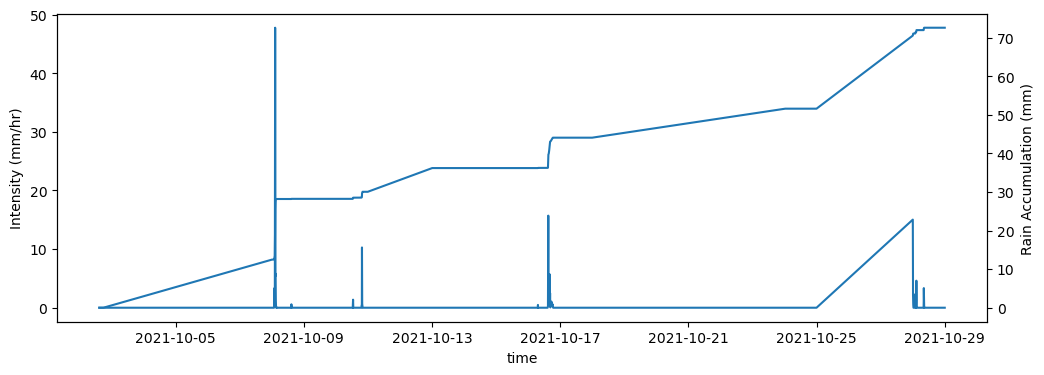

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ds_par.time, ds_par.r_int)
ax1 = ax.twinx()
ax1.plot(ds_par.time, ds_par.r_acc)
ax.set_ylabel('Intensity (mm/hr)')
ax1.set_ylabel('Rain Accumulation (mm)')
ax.set_xlabel('time')

In [25]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [44]:
ds_set = ds_par.sel(time=slice('2021-10-08 01:30', '2021-10-08 03:30'))

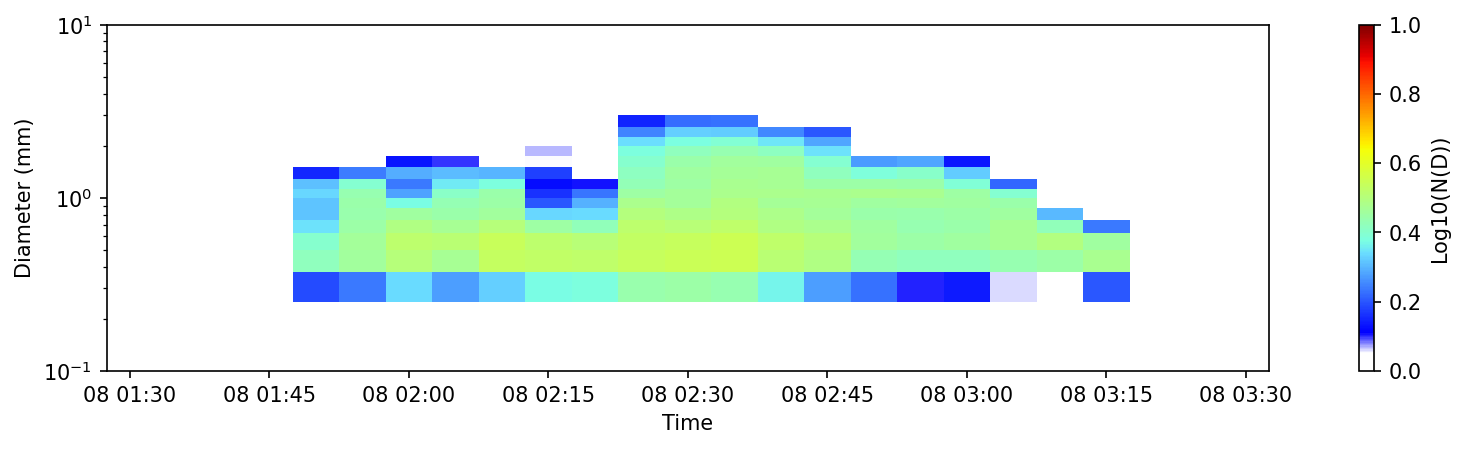

In [48]:
fig, ax0 = plt.subplots(figsize=(10, 3), dpi=150)

cbar = ax0.pcolormesh(ds_set.time.values, 
                      ds_set.diameter, 
                      np.log10(ds_set.nd.T.values), 
                      vmin=0, vmax=1, cmap=my_cmap, shading='nearest')
ax0.set_yscale('log')
ax0.set_ylim(0.1, 10)
ax0.set_xlabel('Time')
ax0.set_ylabel('Diameter (mm)')
add_colorbar_outside(cbar, ax0, 'Log10(N(D))')

### Potential 1 minute resolution (not the same plot, just for reference)
<div class="center">
<img src="../figs/download.png" width="1000"/>
</div>
